# Basics: Aggregation, filtering, limits

This tutorial is based on https://github.com/ibis-project/ibis/tree/master/docs/source/notebooks/tutorial

Now that you have ibis installed and connecting to your `MapD`, let's get our feet wet.

In [1]:
import ibis
con = ibis.mapd.connect(
    host='localhost', user='mapd', password='HyperInteractive',
    port=9091, dbname='mapd'
)

## Accessing a MapD table

The optional `database` parameter allows to fully qualify the table.

In [2]:
table = con.table('flights_2008_10k')
table = con.table('flights_2008_10k', database='mapd')

## Column selection and basic expressions

Selecting columns from a table works just like pandas

In [3]:
col = table.dest_lat

# alternately
col2 = table['distance']

Table columns are equipped with a variety of math operations and other methods to assist in writing your analytics. For example:

In [4]:
expr = col.log2() - 1

Some operations transform arrays to arrays, while others aggregate, like `sum` and `mean`:

In [5]:
expr2 = expr.sum()

The methods that are available on columns depend on the type of the column. For example, you won't see the `substr` or `upper` methods for strings on numeric columns:

In [6]:
substr_expr = table.origin_name.upper().substr(0, 2)

Notice that printing the expressions to the console does not actually do anything, and shows a graphical representation of the expression you've built.

**Note: don't worry too much about the details of the expression tree that's outputted, it's very likely to change over time**

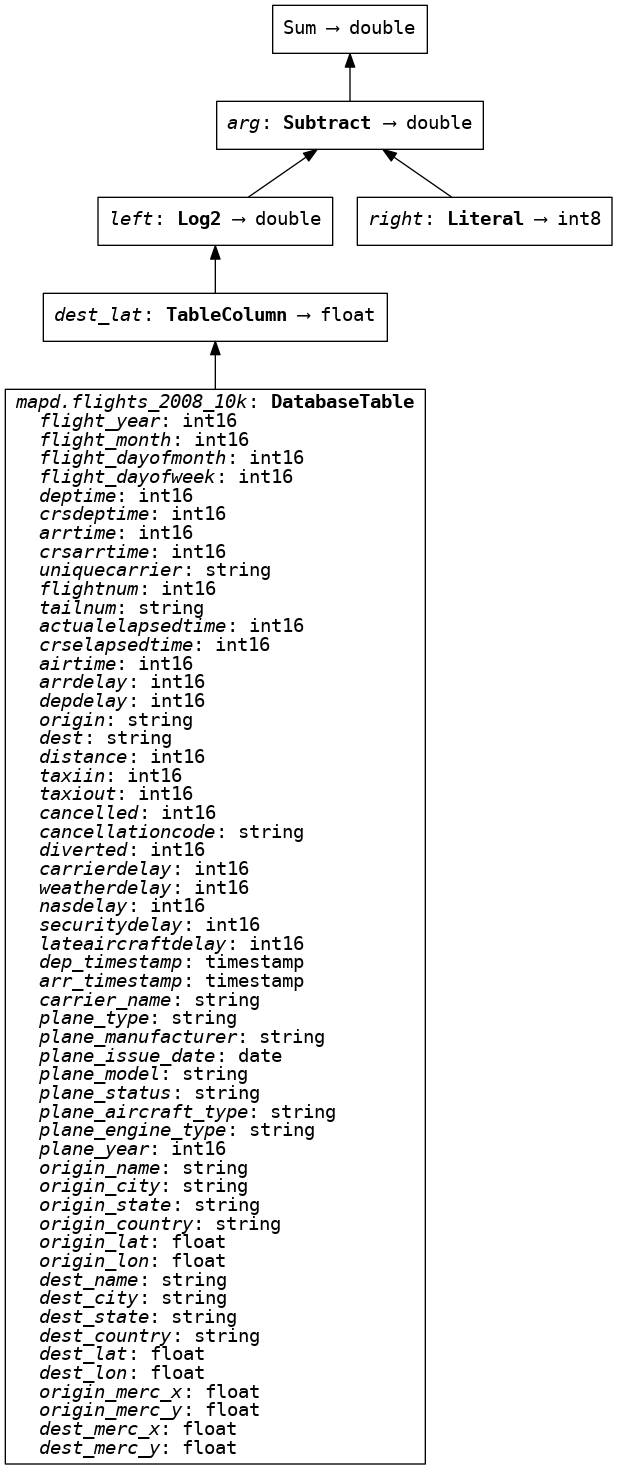

In [7]:
expr2

We can also execute an expression by calling `execute` on the **MapD** connection object

In [8]:
con.execute(col.sum().name('sum1'))

360006.28125

There's a shortcut to make this a little more convenient in interactive use

## Interactive mode


Many Ibis expressions can be immediately executed against the database, and it may improve your productivity to have the executed for you whenever you try to print the expression in the console / IPython notebook.

To do this, we have an *interactive* mode available, which can be turned on/off like so:

In [9]:
ibis.options.interactive = True

Now, any expressions you write will be executed right away

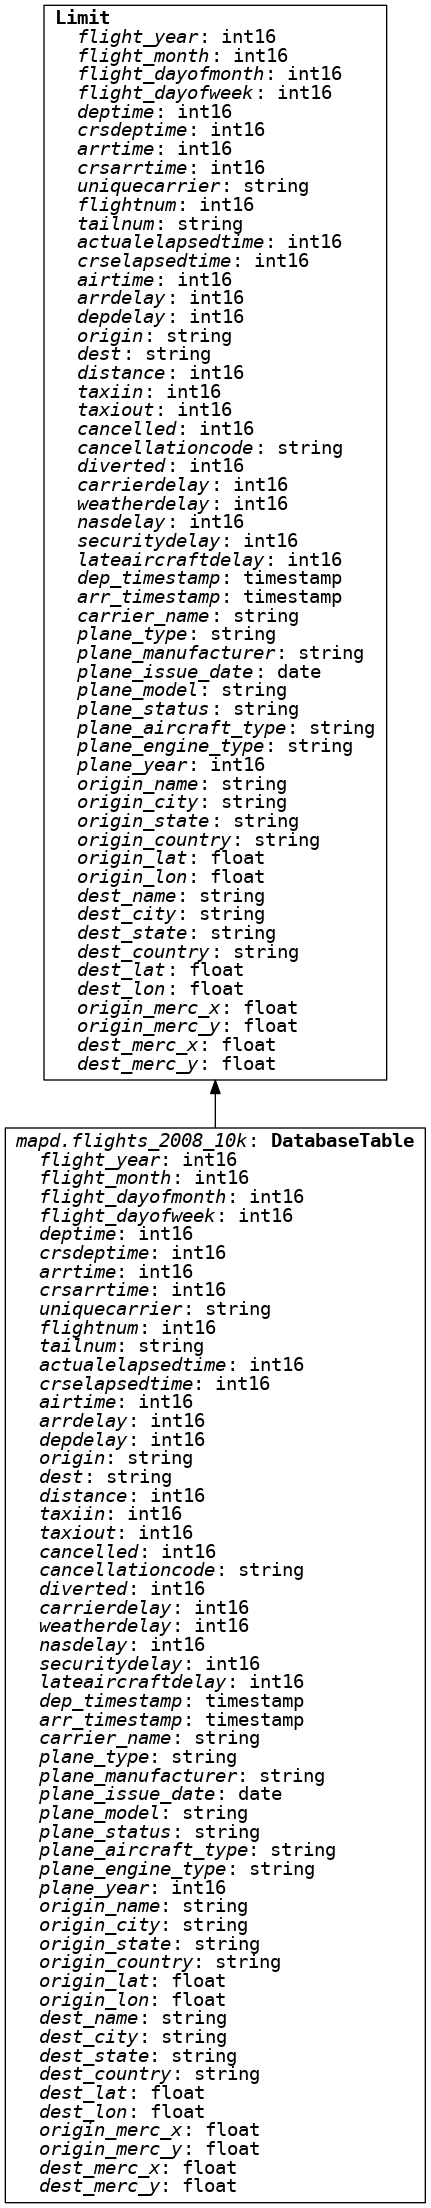

In [10]:
table.limit(10)

You can select a row range with slicing syntax:

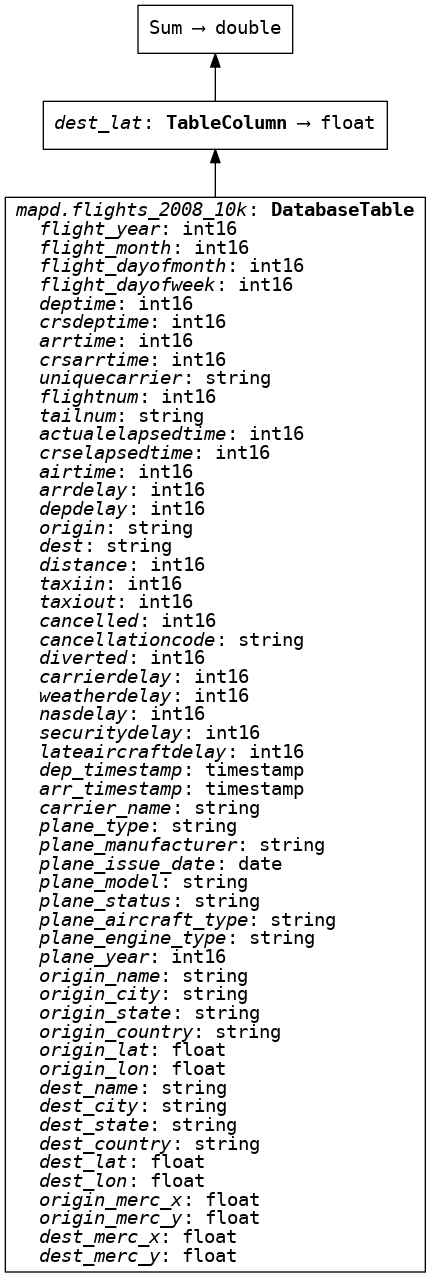

In [11]:
table.dest_lat.sum().name('sum1')

Don't worry about the syntax here, but expressions resulting in tabular output will come back as a pandas DataFrame by default:

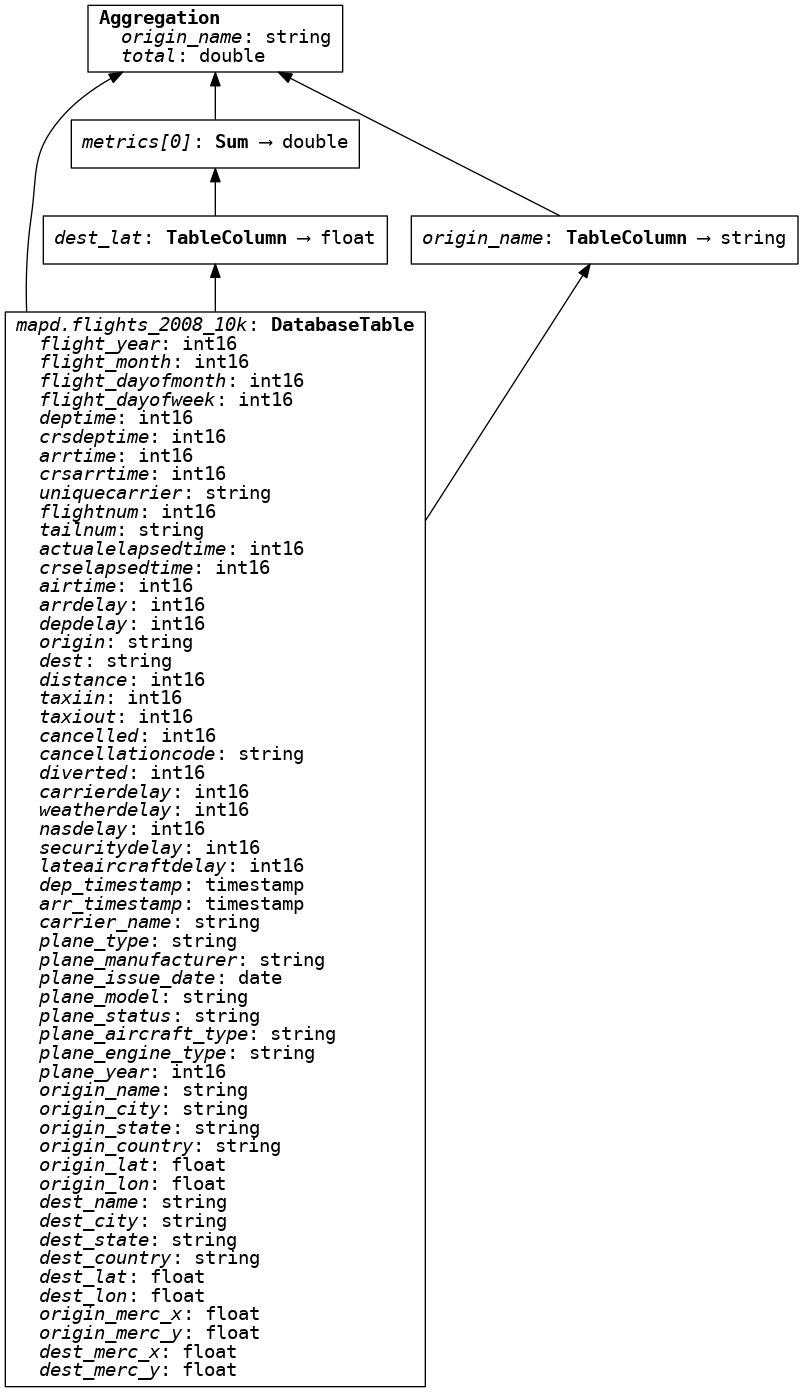

In [12]:
metrics = [table.dest_lat.sum().name('total')]
expr = table.group_by('origin_name').aggregate(metrics)
expr

## Verbose mode and logging


You may want to see or log all the **MapD** queries that Ibis executes under the hood. To do that, use the `options.verbose` option:

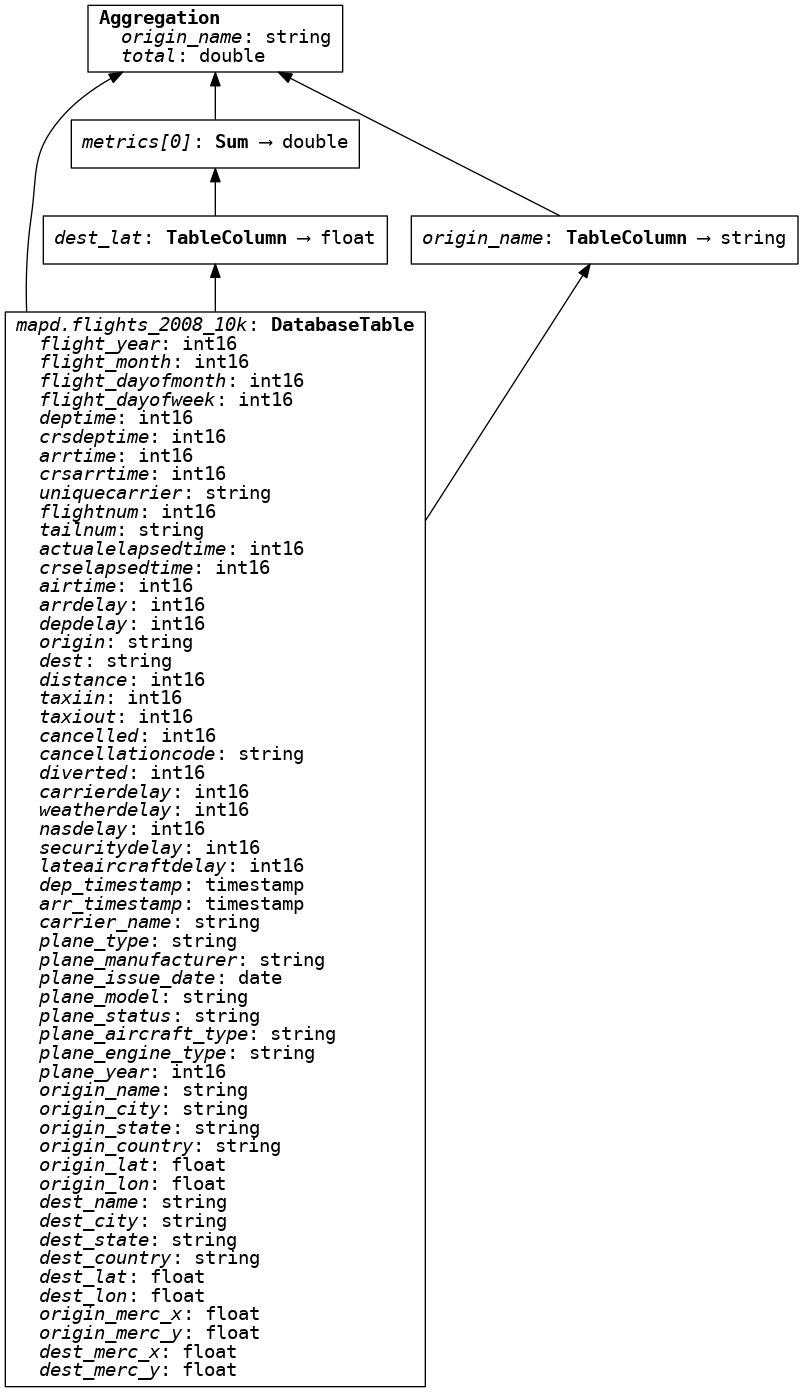

In [13]:
ibis.options.verbose = True

metrics = [table.dest_lat.sum().name('total')]
expr = table.group_by('origin_name').aggregate(metrics)
expr

In [14]:
queries = []
def logger(x):
    queries.append(x)
    
ibis.options.verbose_log = logger

expr.execute()
expr.execute()

queries

[]

In [15]:
from __future__ import print_function
ibis.options.verbose_log = lambda x: print(x)
ibis.options.verbose = False

Aggregation basics
---

One of the essential table API functions is `aggregate`. Aggregation involves the following

- One or more *named* aggregate expressions, or *reductions*
- Zero or more grouping expressions or column names

This ends up working very similarly to pandas's **groupby** mechanism.

Let's start with a simple reduction:

In [16]:
metric = table.dest_lat.sum().name('sum1')

As you saw above, you can execute this immediately and obtain a value:

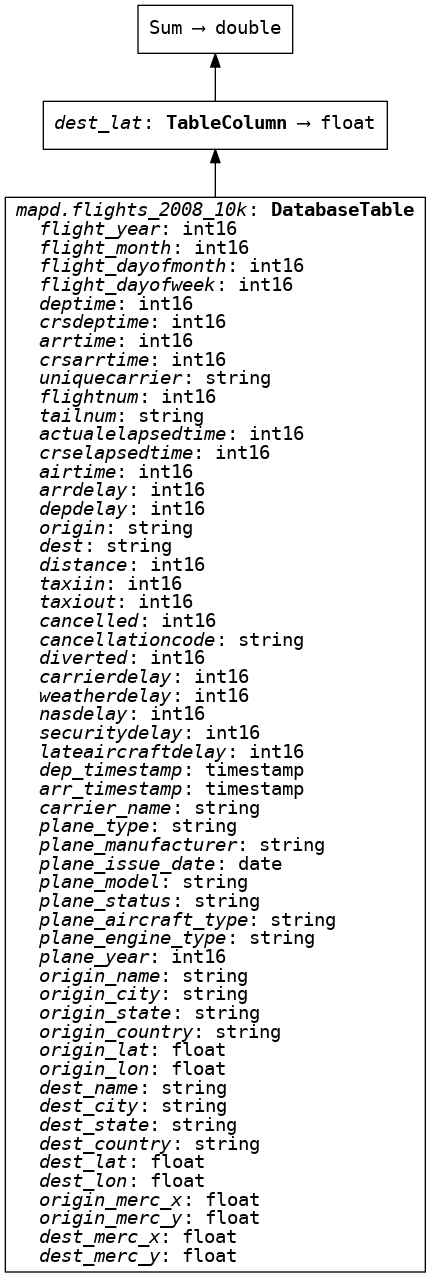

In [17]:
metric

The reduced column can be more complex; for example, you could count the number of null values in a column like so:

DatabaseError: Exception: Exception occurred: org.apache.calcite.runtime.CalciteContextException: From line 1, column 12 to line 1, column 35: No match found for function signature zeroifnull(<NUMERIC>)

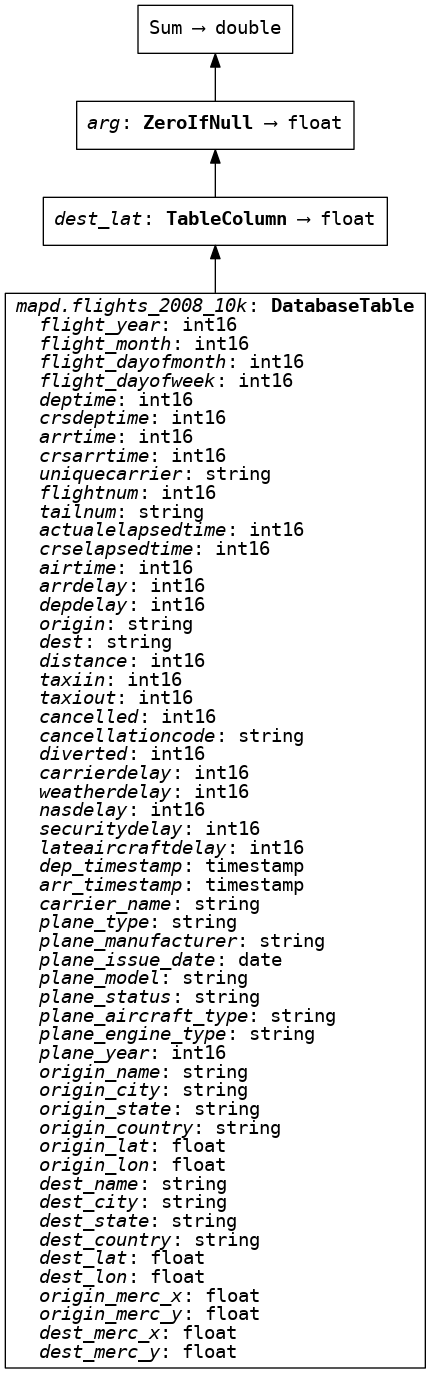

In [34]:
table.dest_lat.zeroifnull().sum().name('sum1')

To aggregate a table, potentially with grouping keys, we have to give the reduction a name and call `aggregate`

In [19]:
metric = metric.name('dest_lat')
expr = table.aggregate([metric])
result = con.execute(expr)
result

dest_lat
0  360006.28125

The result here is actually a pandas DataFrame with 1 row and just the one column. We can add another metric and add a grouping key

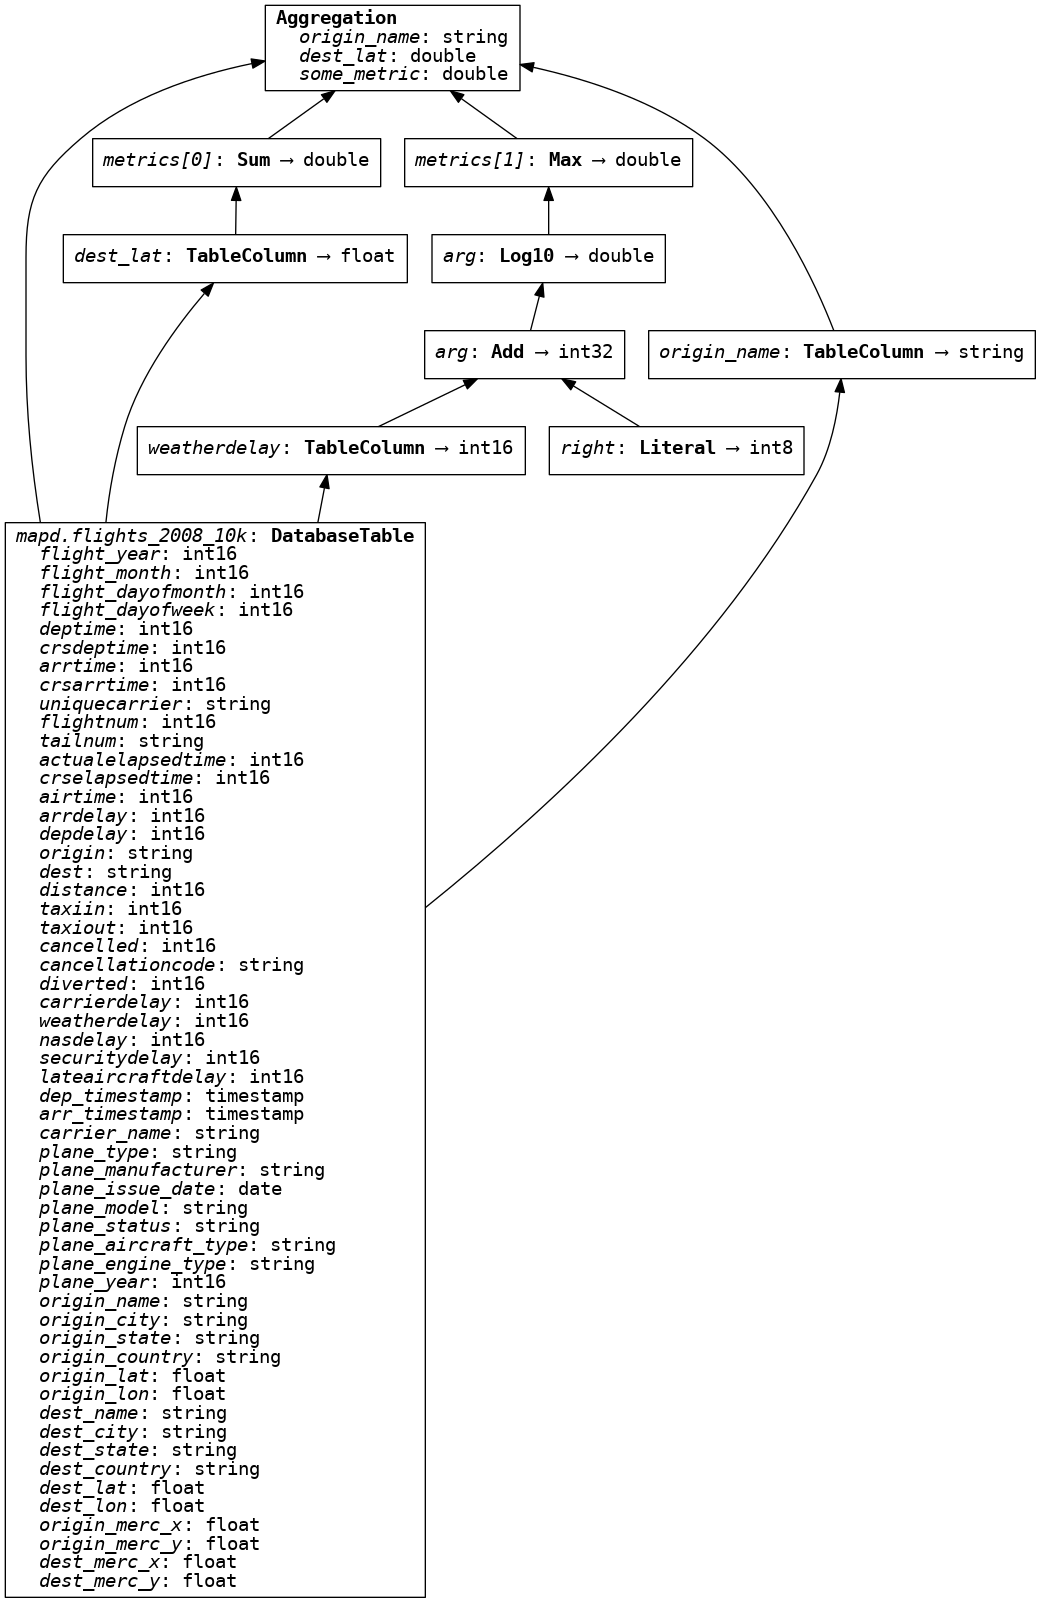

In [20]:
metric2 = (table.weatherdelay + 1).log10().max().name('some_metric')

expr = table.aggregate([metric, metric2], by=['origin_name'])
expr

We provide a convenience `group_by`, a la pandas, to make this a little more composable:

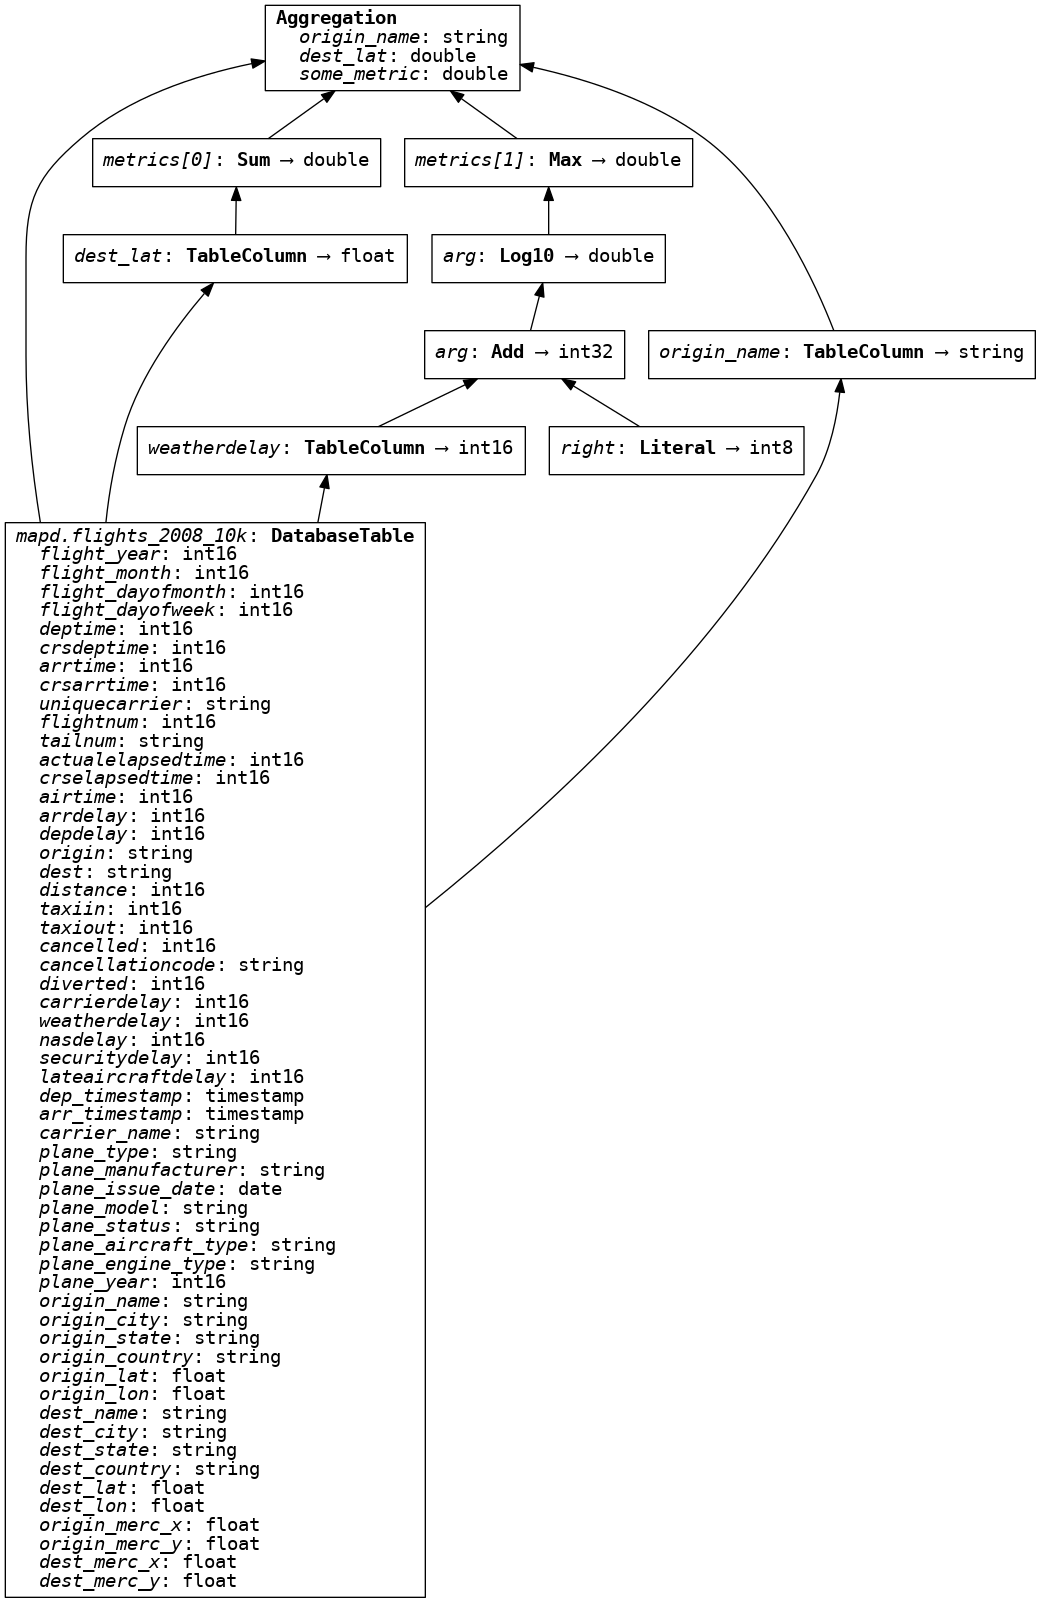

In [21]:
expr = (table.group_by('origin_name')
        .aggregate([metric, metric2]))
expr

You can also group by named column expressions

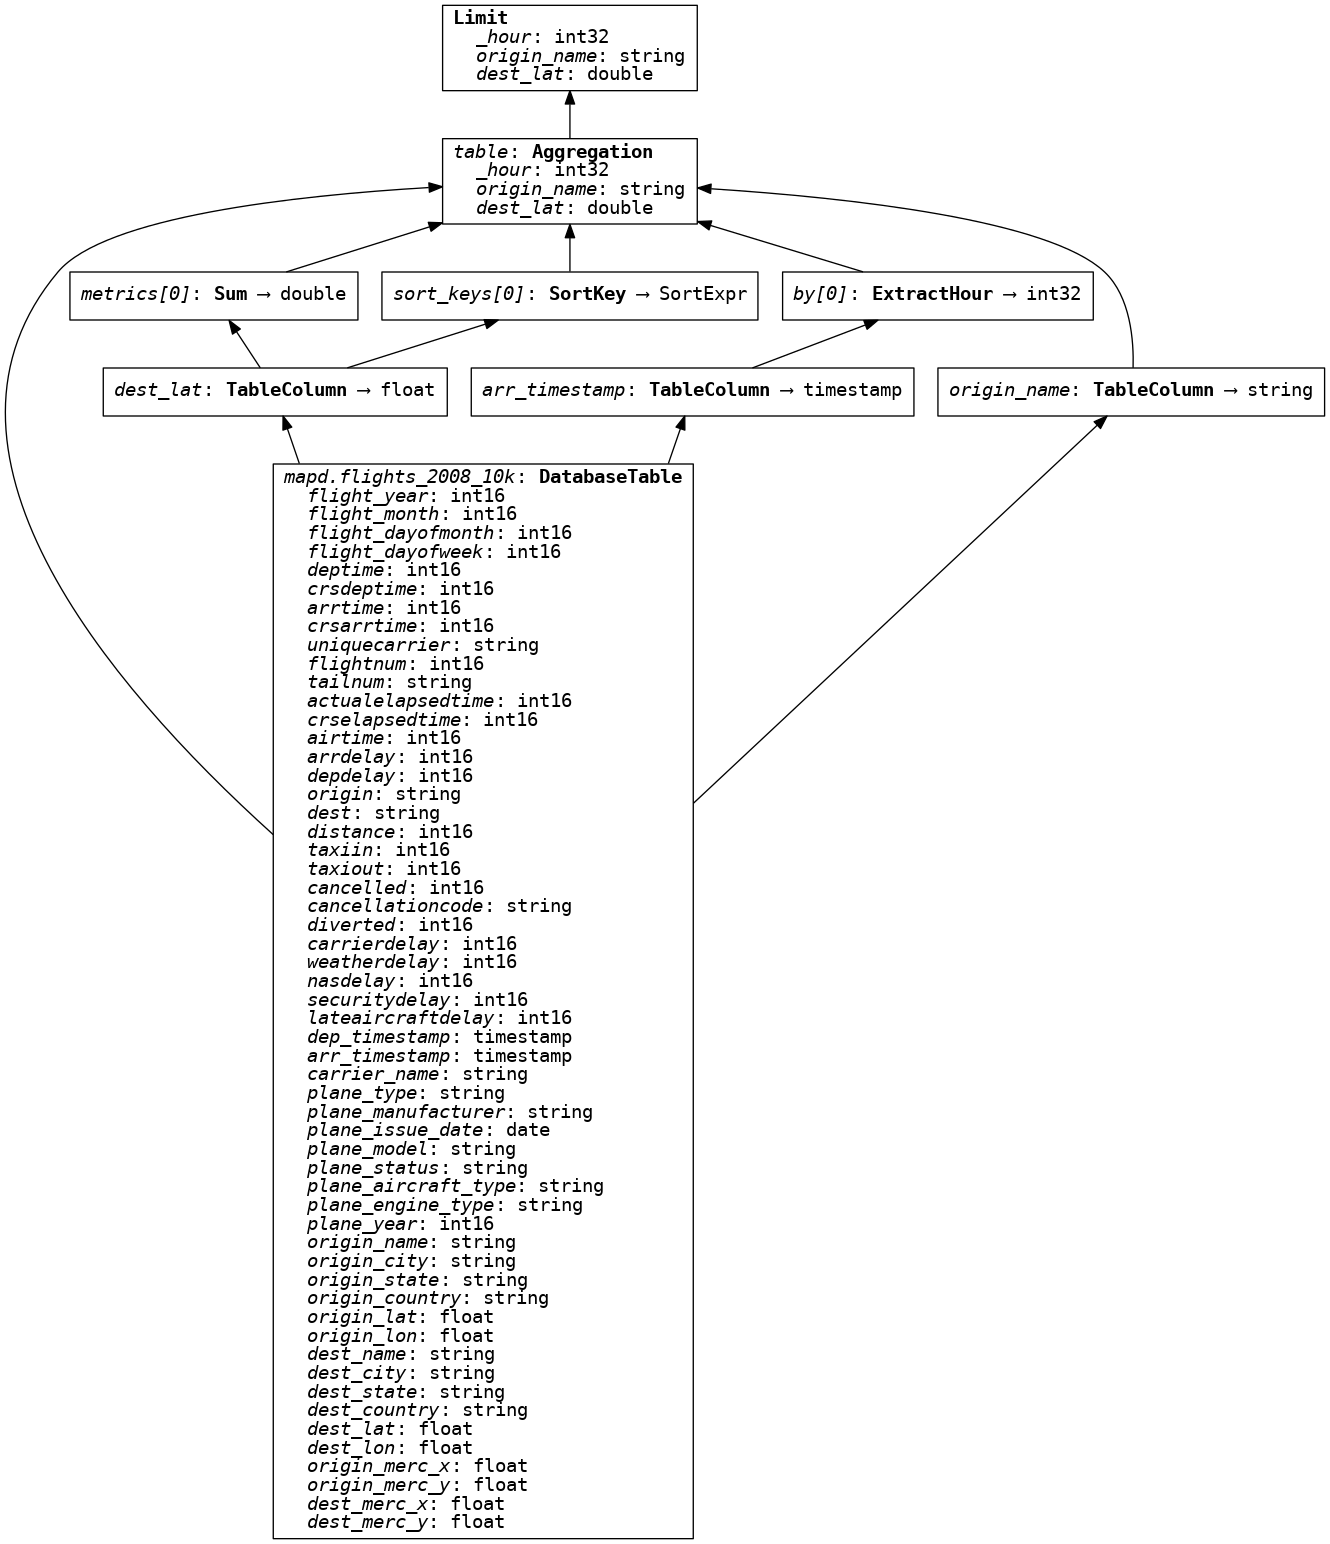

In [22]:
keys = [table.arr_timestamp.hour().name('_hour'), 'origin_name']

expr = table.group_by(keys).aggregate([metric])

# Top 10 by double_total, more on this later
expr.sort_by([('dest_lat', False)]).limit(10)

In most cases, an aggregation by itself can be evaluated:

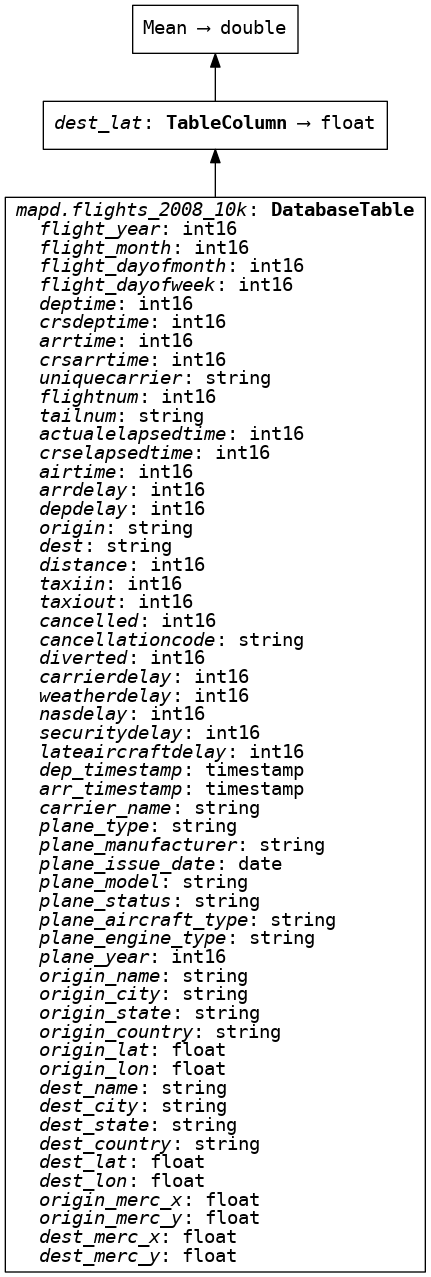

In [23]:
table.dest_lat.mean()

This can also be done in simple cases along with `group_by`:

In [24]:
# TODO: resolve aggregation name
table.group_by('origin_name').dest_lat.mean().compile()

'SELECT "origin_name", avg("dest_lat") AS mean(dest_lat)\nFROM mapd.flights_2008_10k\nGROUP BY origin_name'

Many reduction functions have a default expression name, unlike many other Ibis expressions (for now!), to make some common analyses easier:

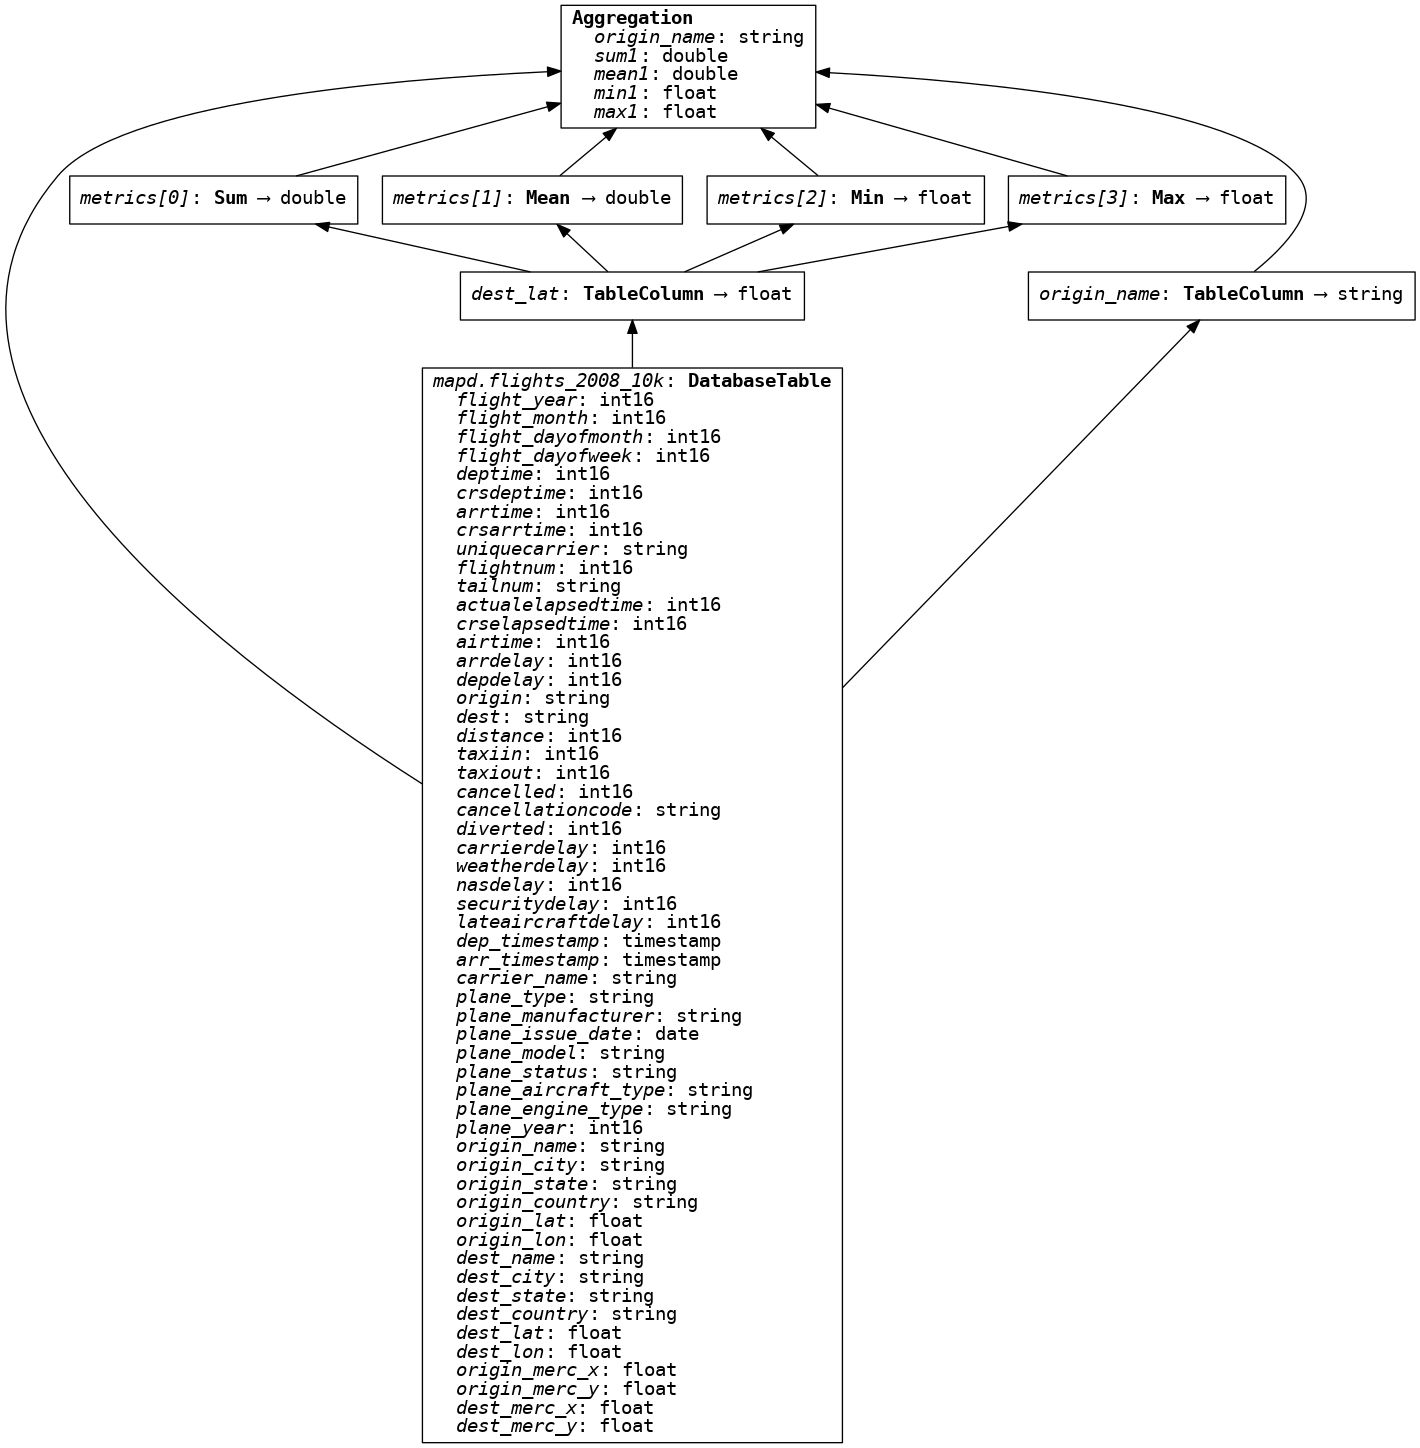

In [25]:
# TODO: resolve aggregation name
d = table.dest_lat

(table.group_by('origin_name')
 .aggregate([
     d.sum().name('sum1'), 
     d.mean().name('mean1'), 
     d.min().name('min1'), 
     d.max().name('max1')
 ]))

Of course, for this _particular_ case you can always use `summary`

In [26]:
# TODO
# table.group_by('origin_name').dest_lat.summary()

## Filtering

Filtering tables works similarly to pandas

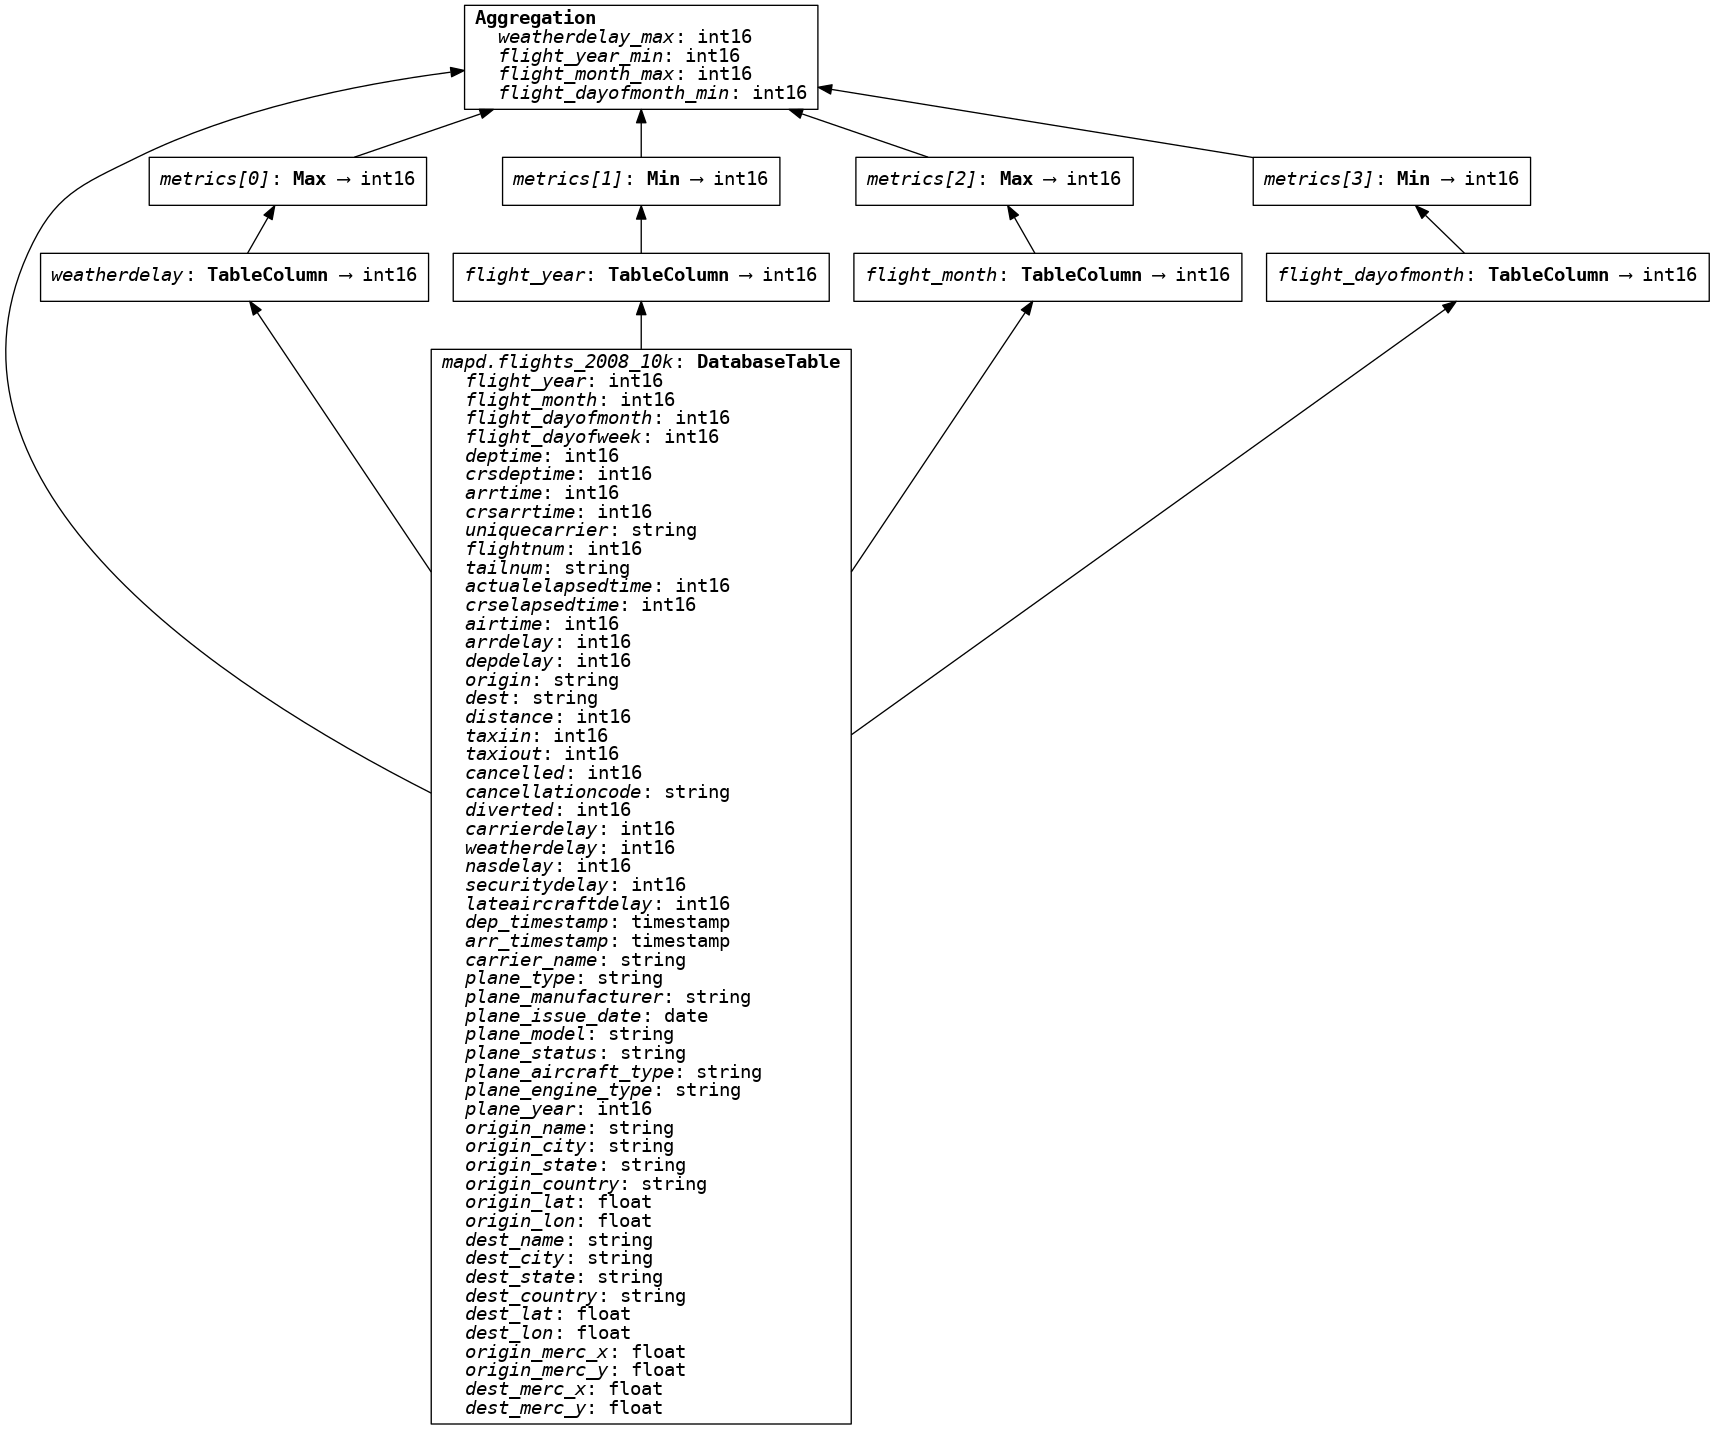

In [27]:
table.aggregate([table.weatherdelay.max().name('weatherdelay_max'),
                 table.flight_year.min().name('flight_year_min'),
                 table.flight_month.max().name('flight_month_max'),
                 table.flight_dayofmonth.min().name('flight_dayofmonth_min')])

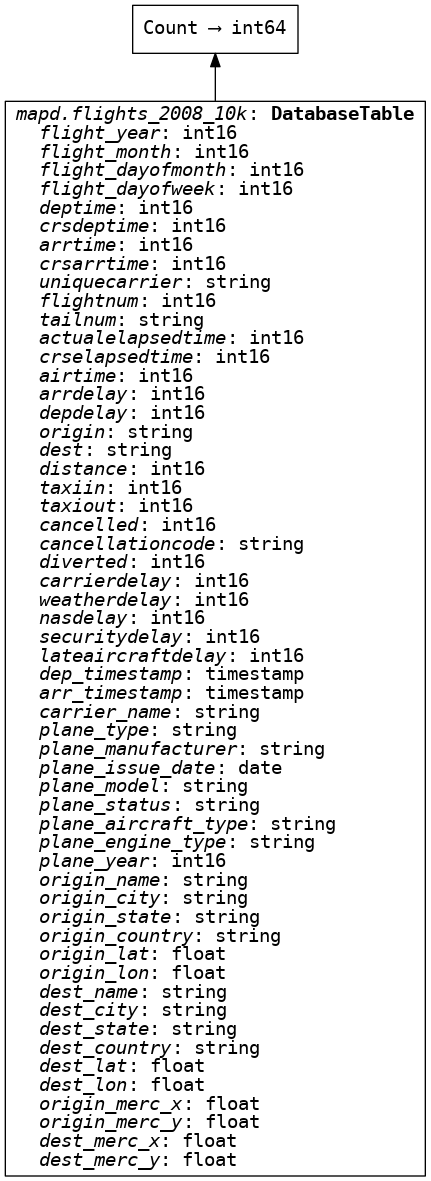

In [28]:
# TODO: resolve aggregation name
table.count().name('count1')

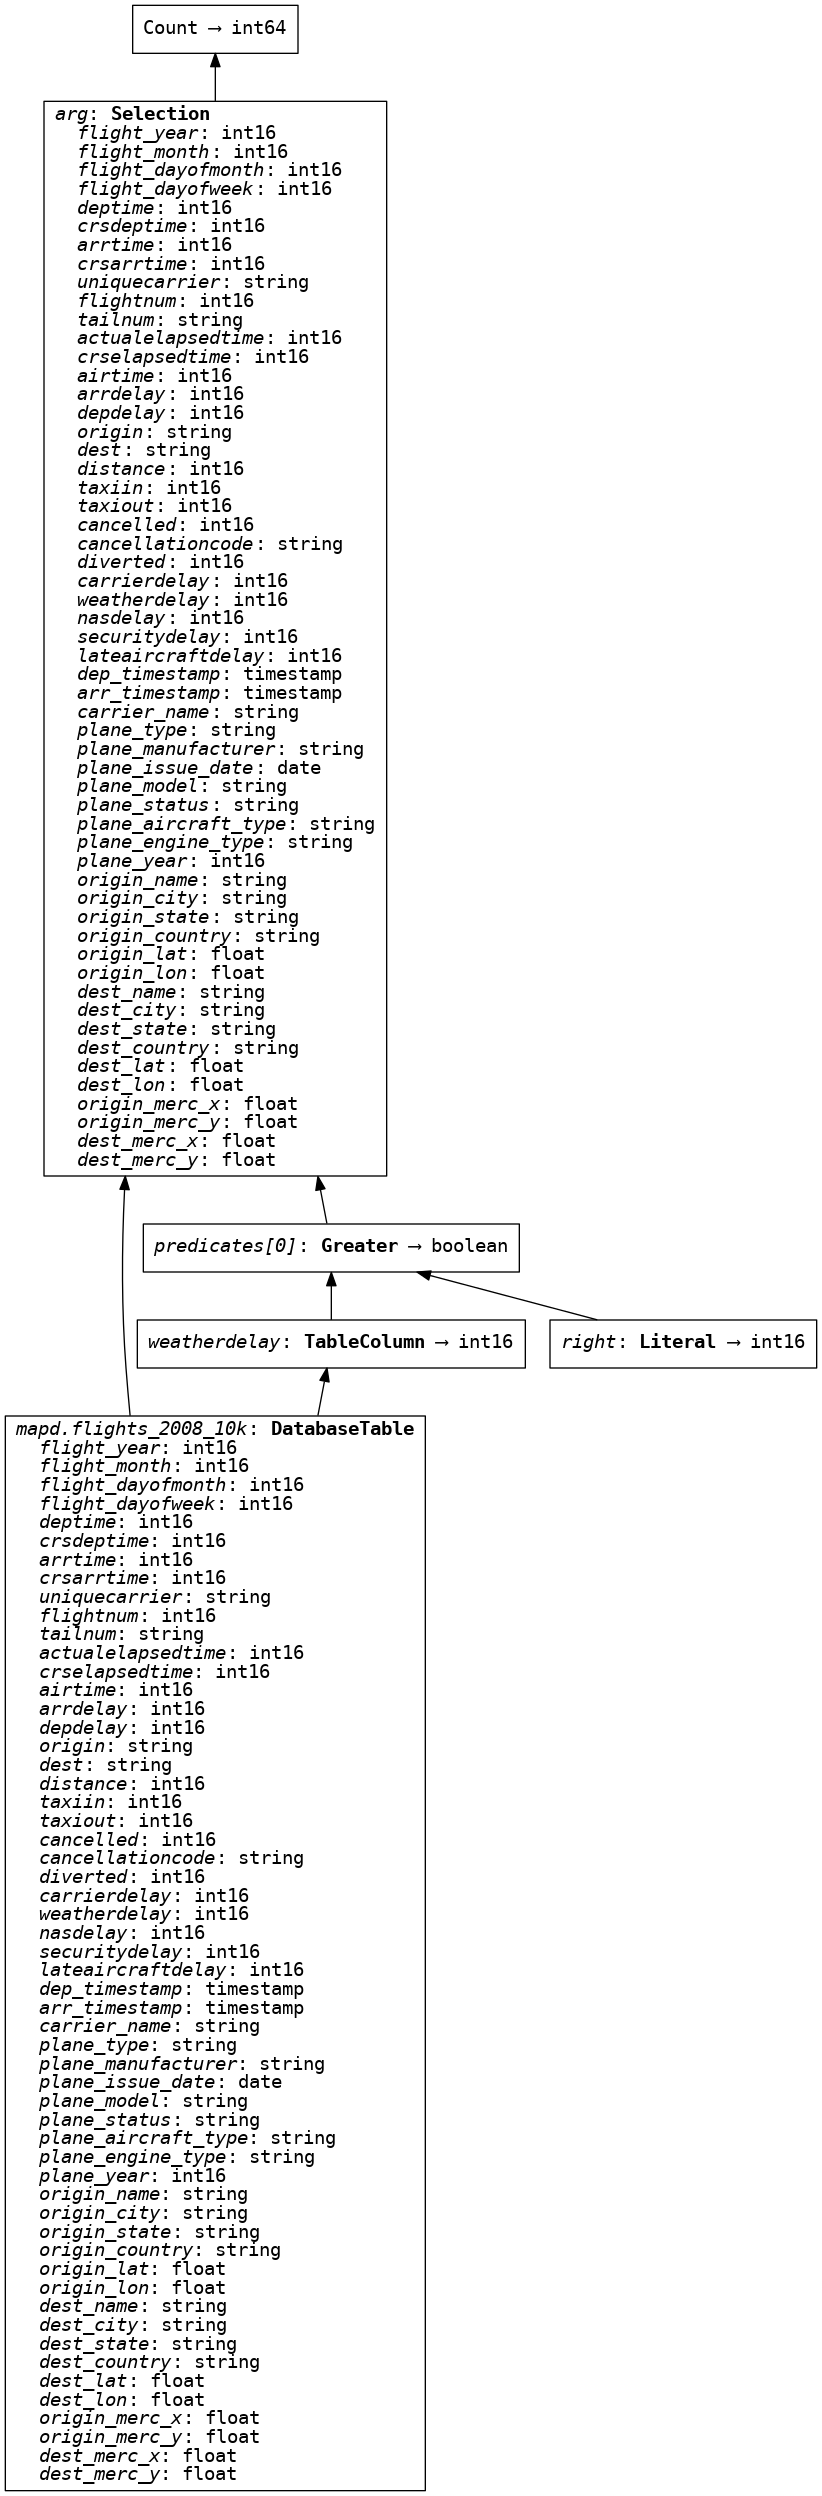

In [29]:
# TODO: resove aggregation name
table[table.weatherdelay > 50].count().name('count1')

Filters can be composed using & (and), | (or), and other logical array operators

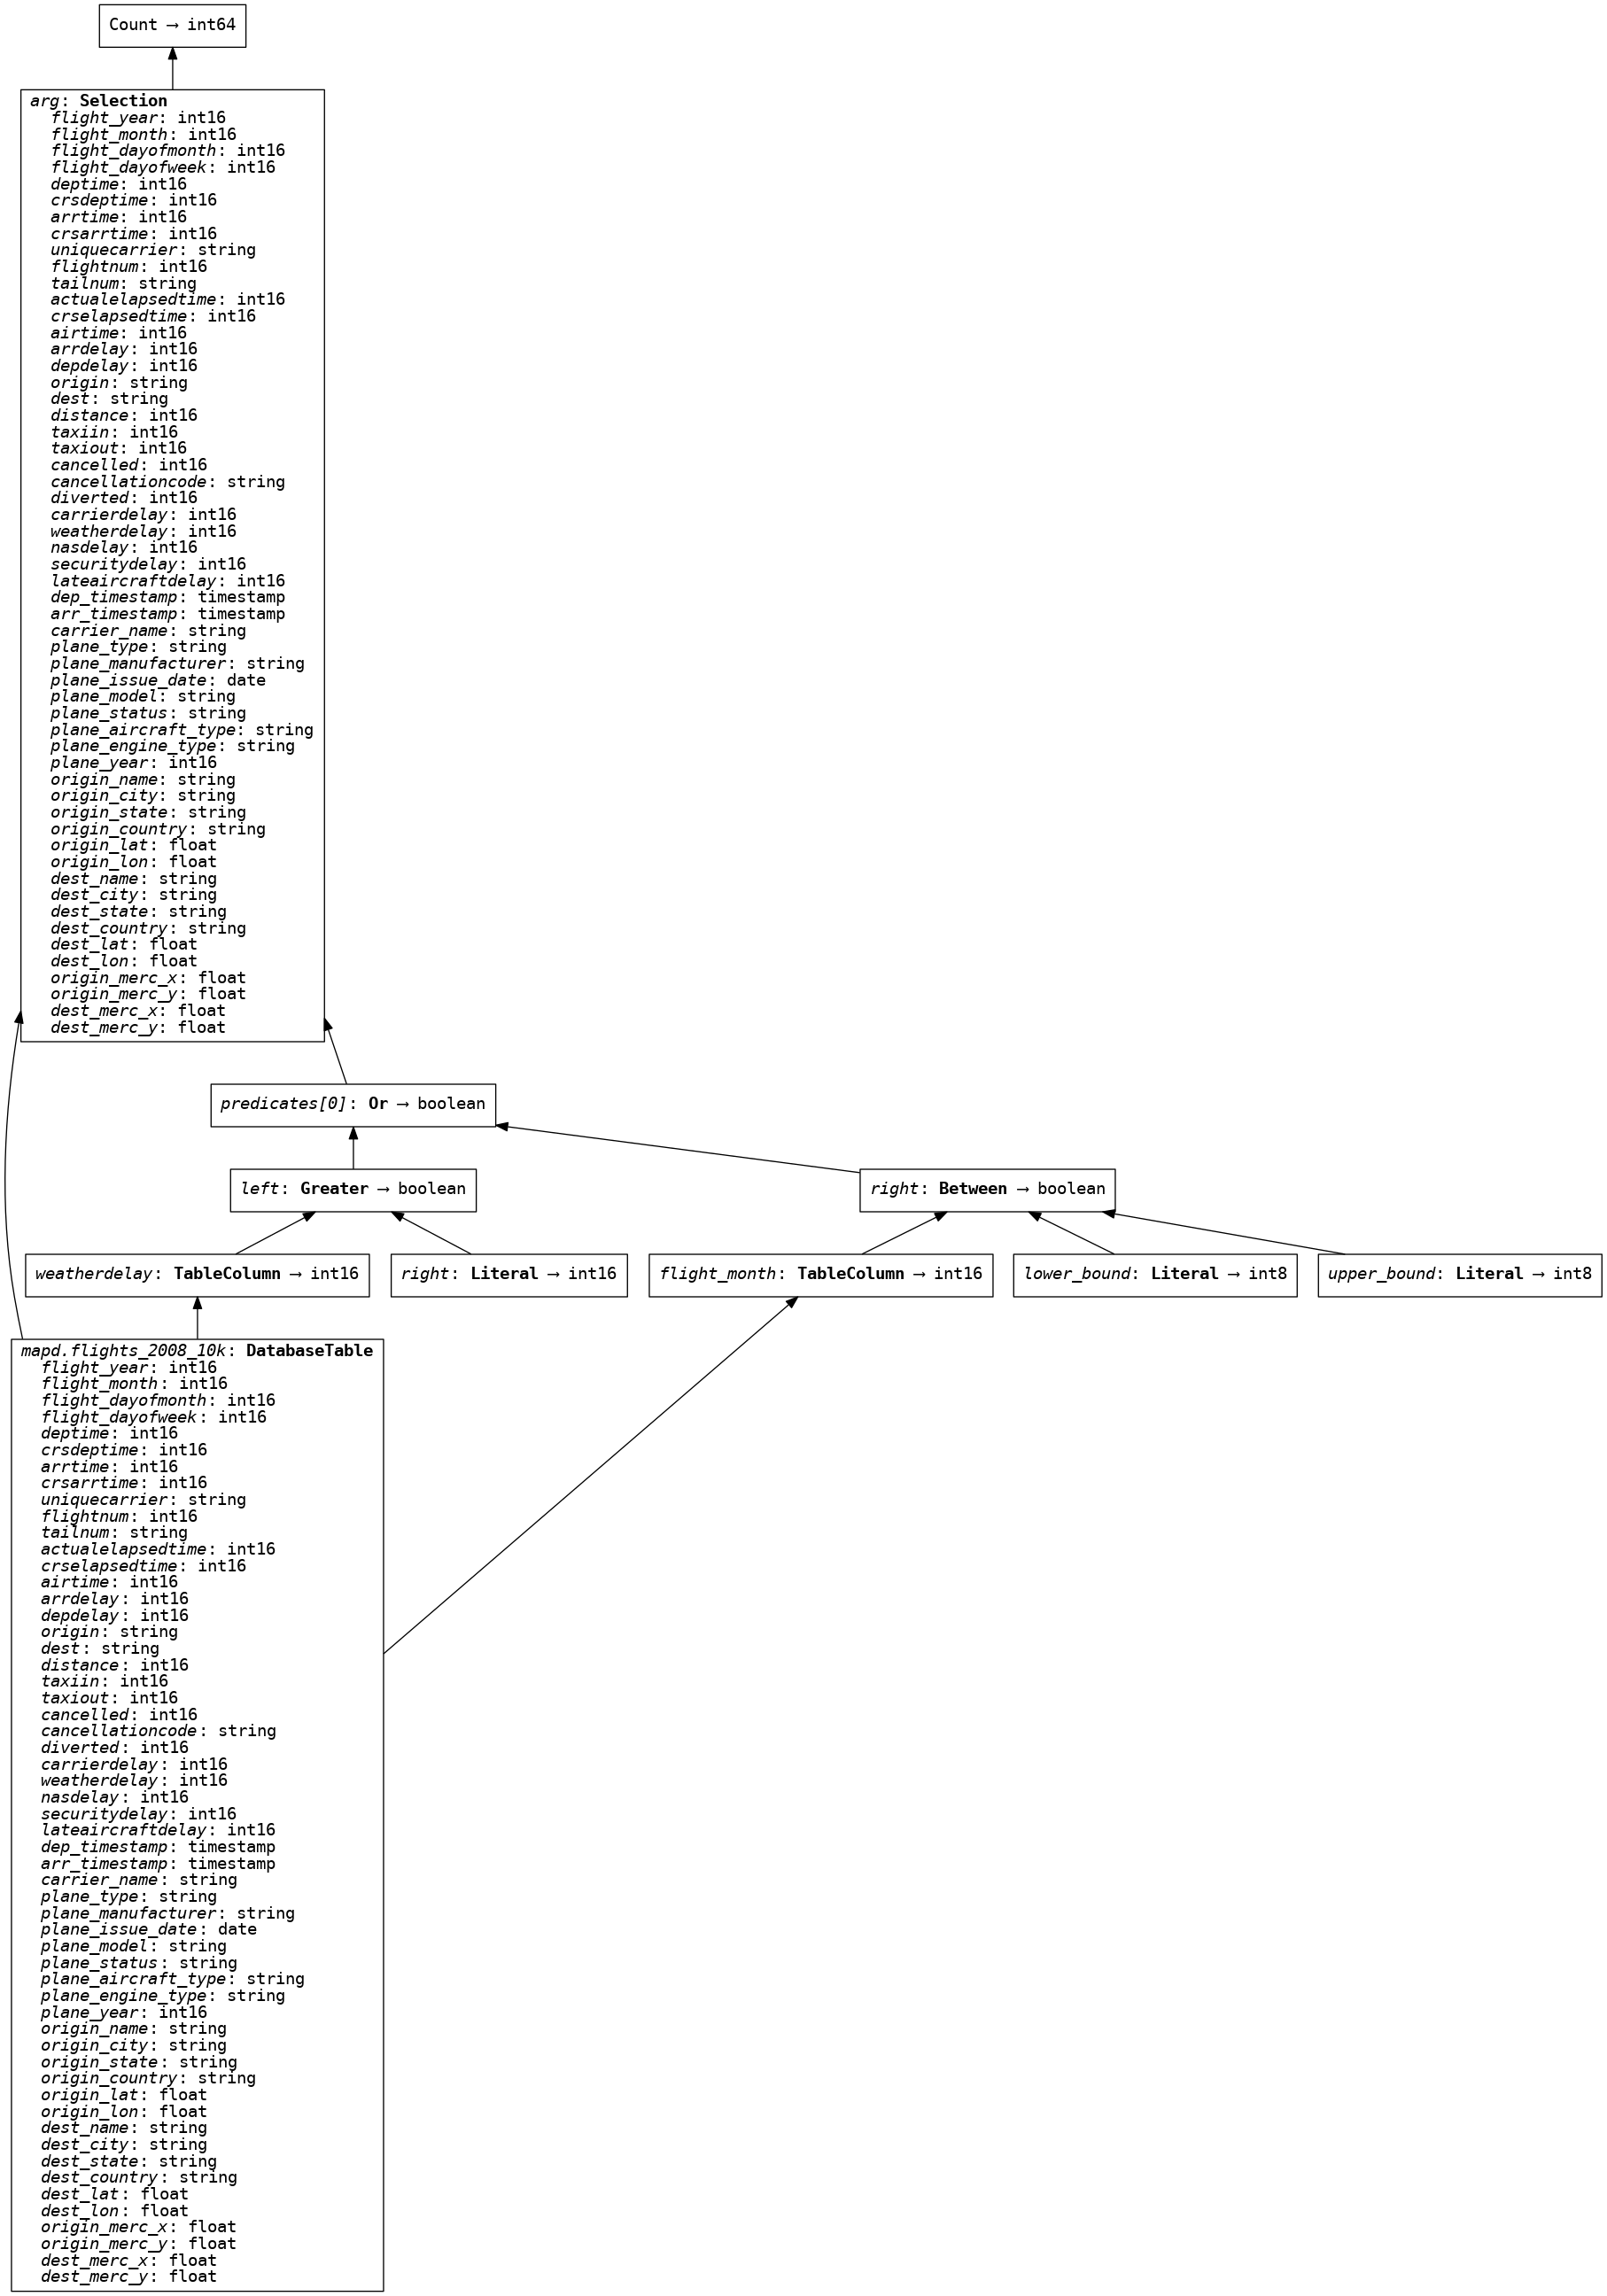

In [30]:
# TODO: resolve aggregation name
cond1 = table.weatherdelay > 50
cond2 = table.flight_month.between(2, 7)
table[cond1 | cond2].count().name('count1')

There's a `filter` function that allows you to pass a list of conditions (that are all required to hold):

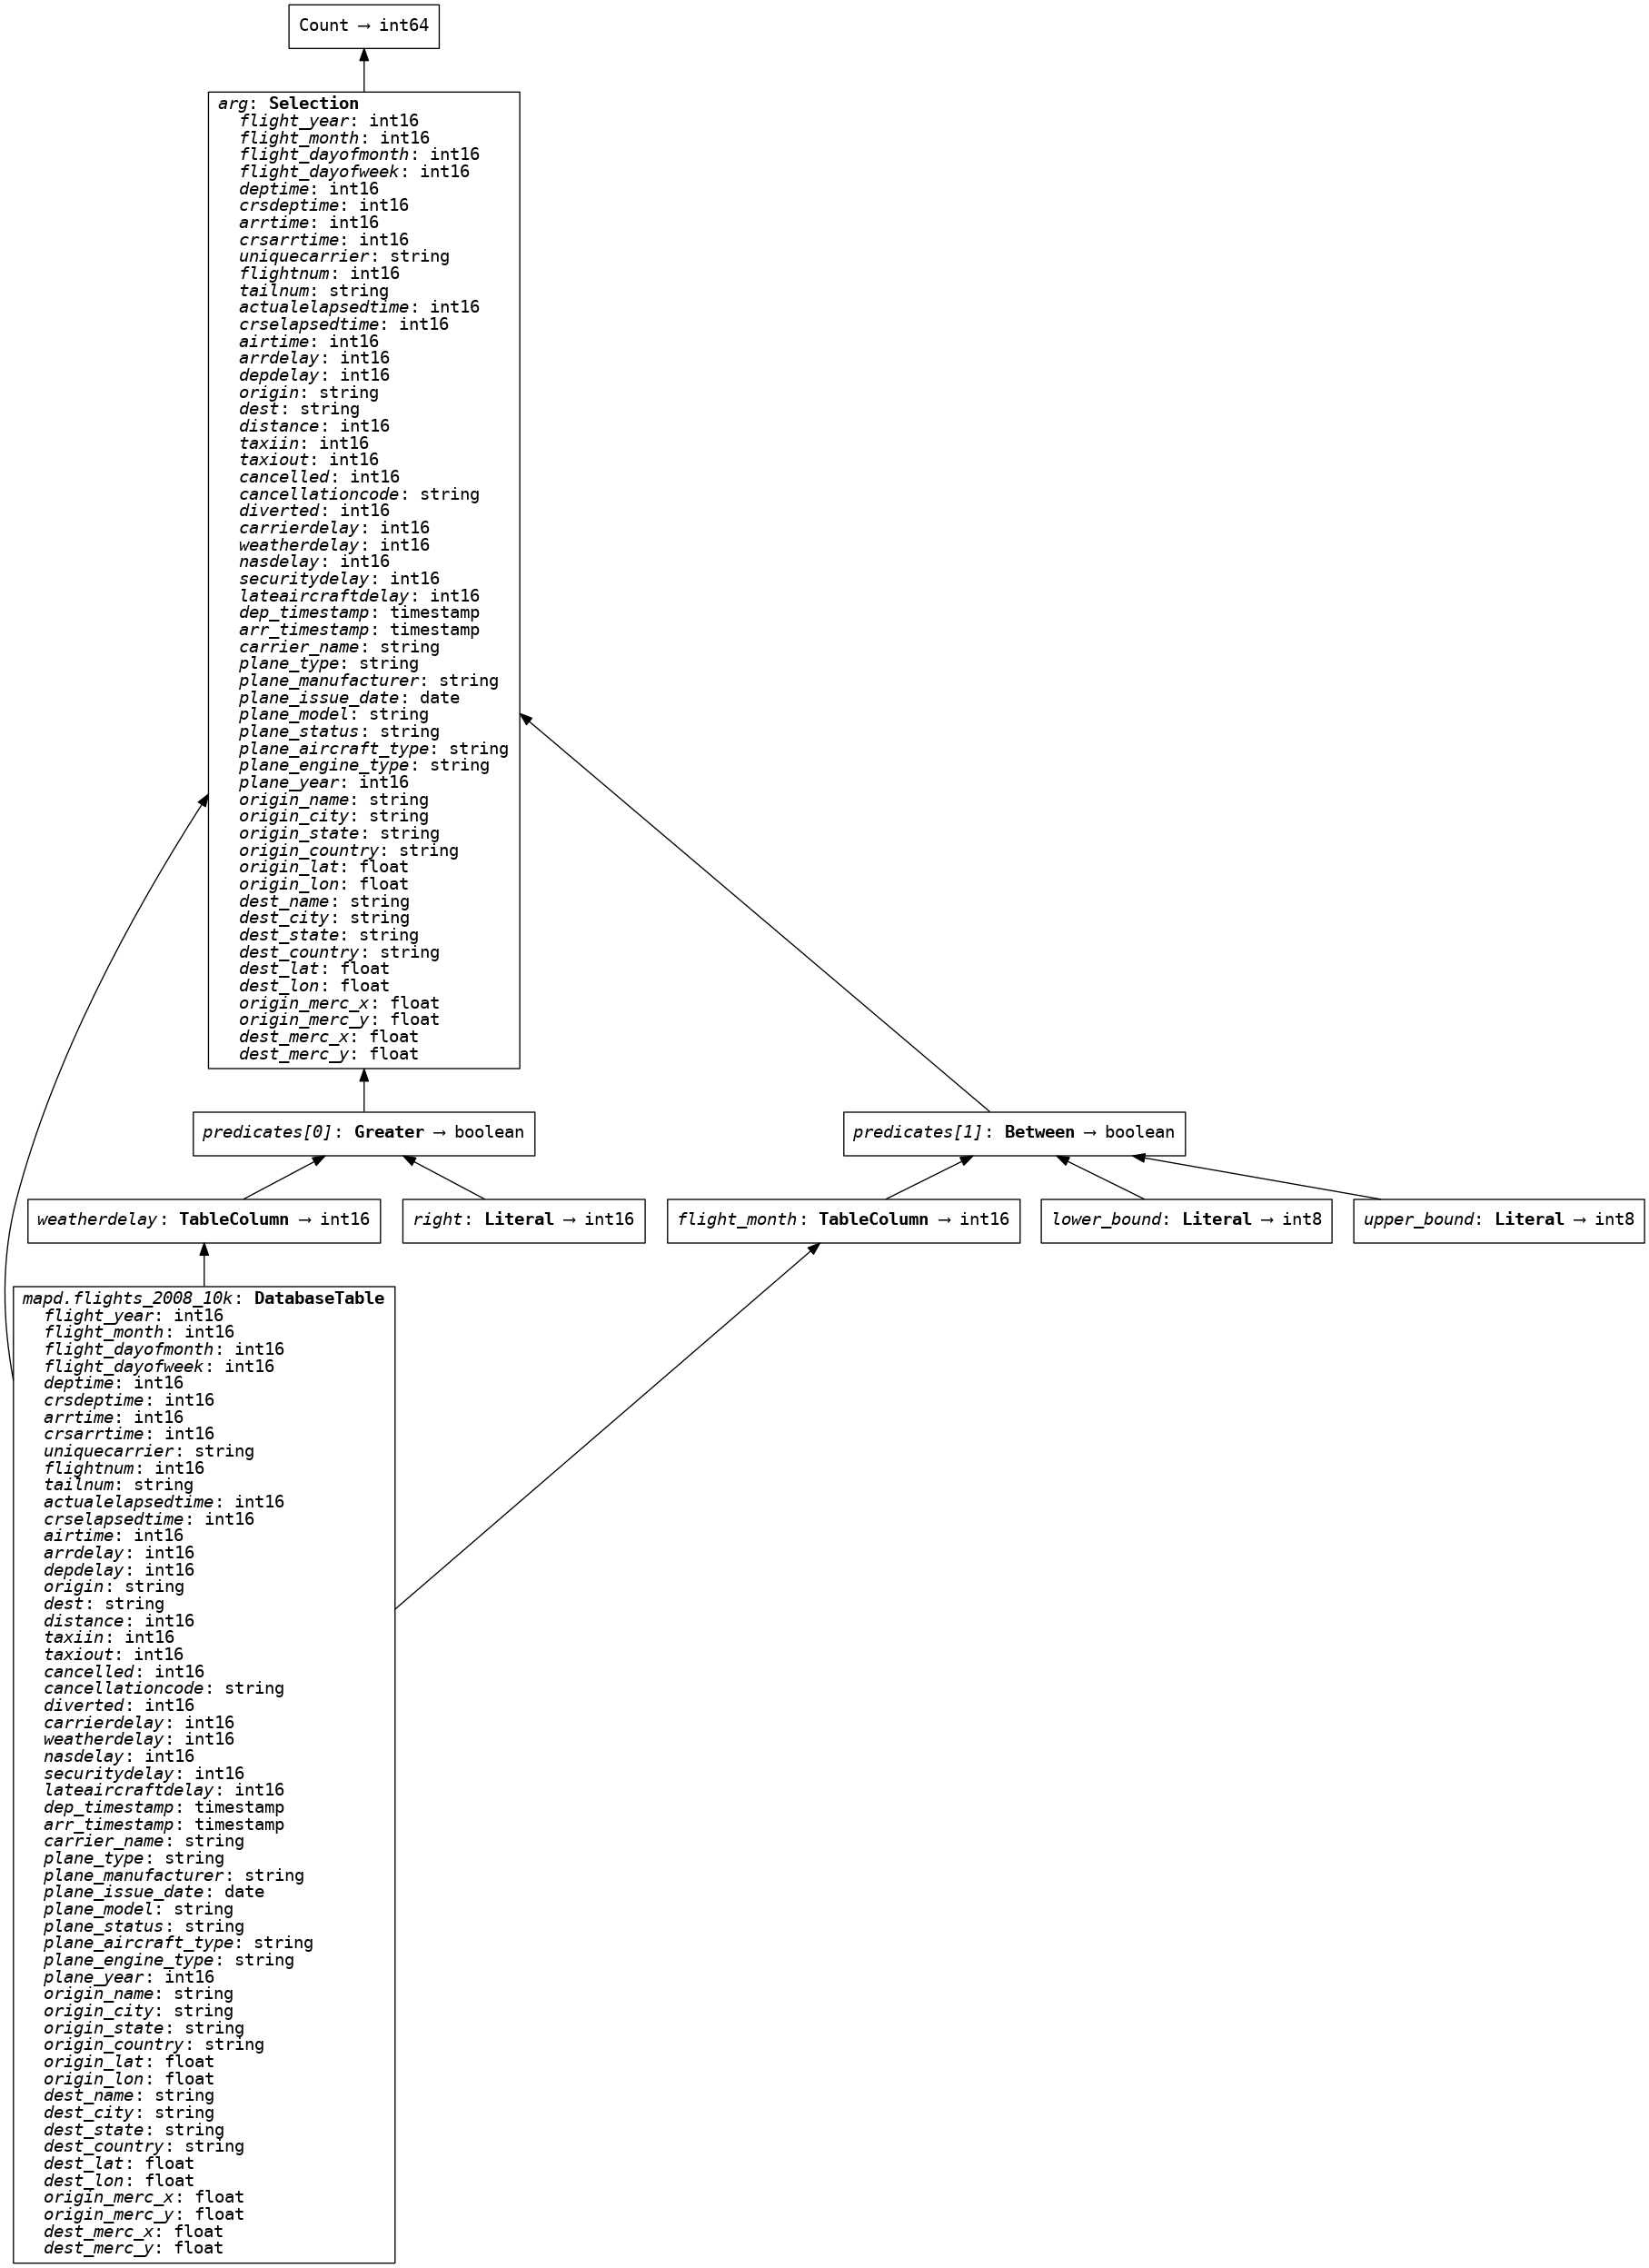

In [31]:
# TODO: resolve aggregation name
table.filter([cond1, cond2]).count().name('count1')

Note this is the same as &-ing the boolean conditions yourself:

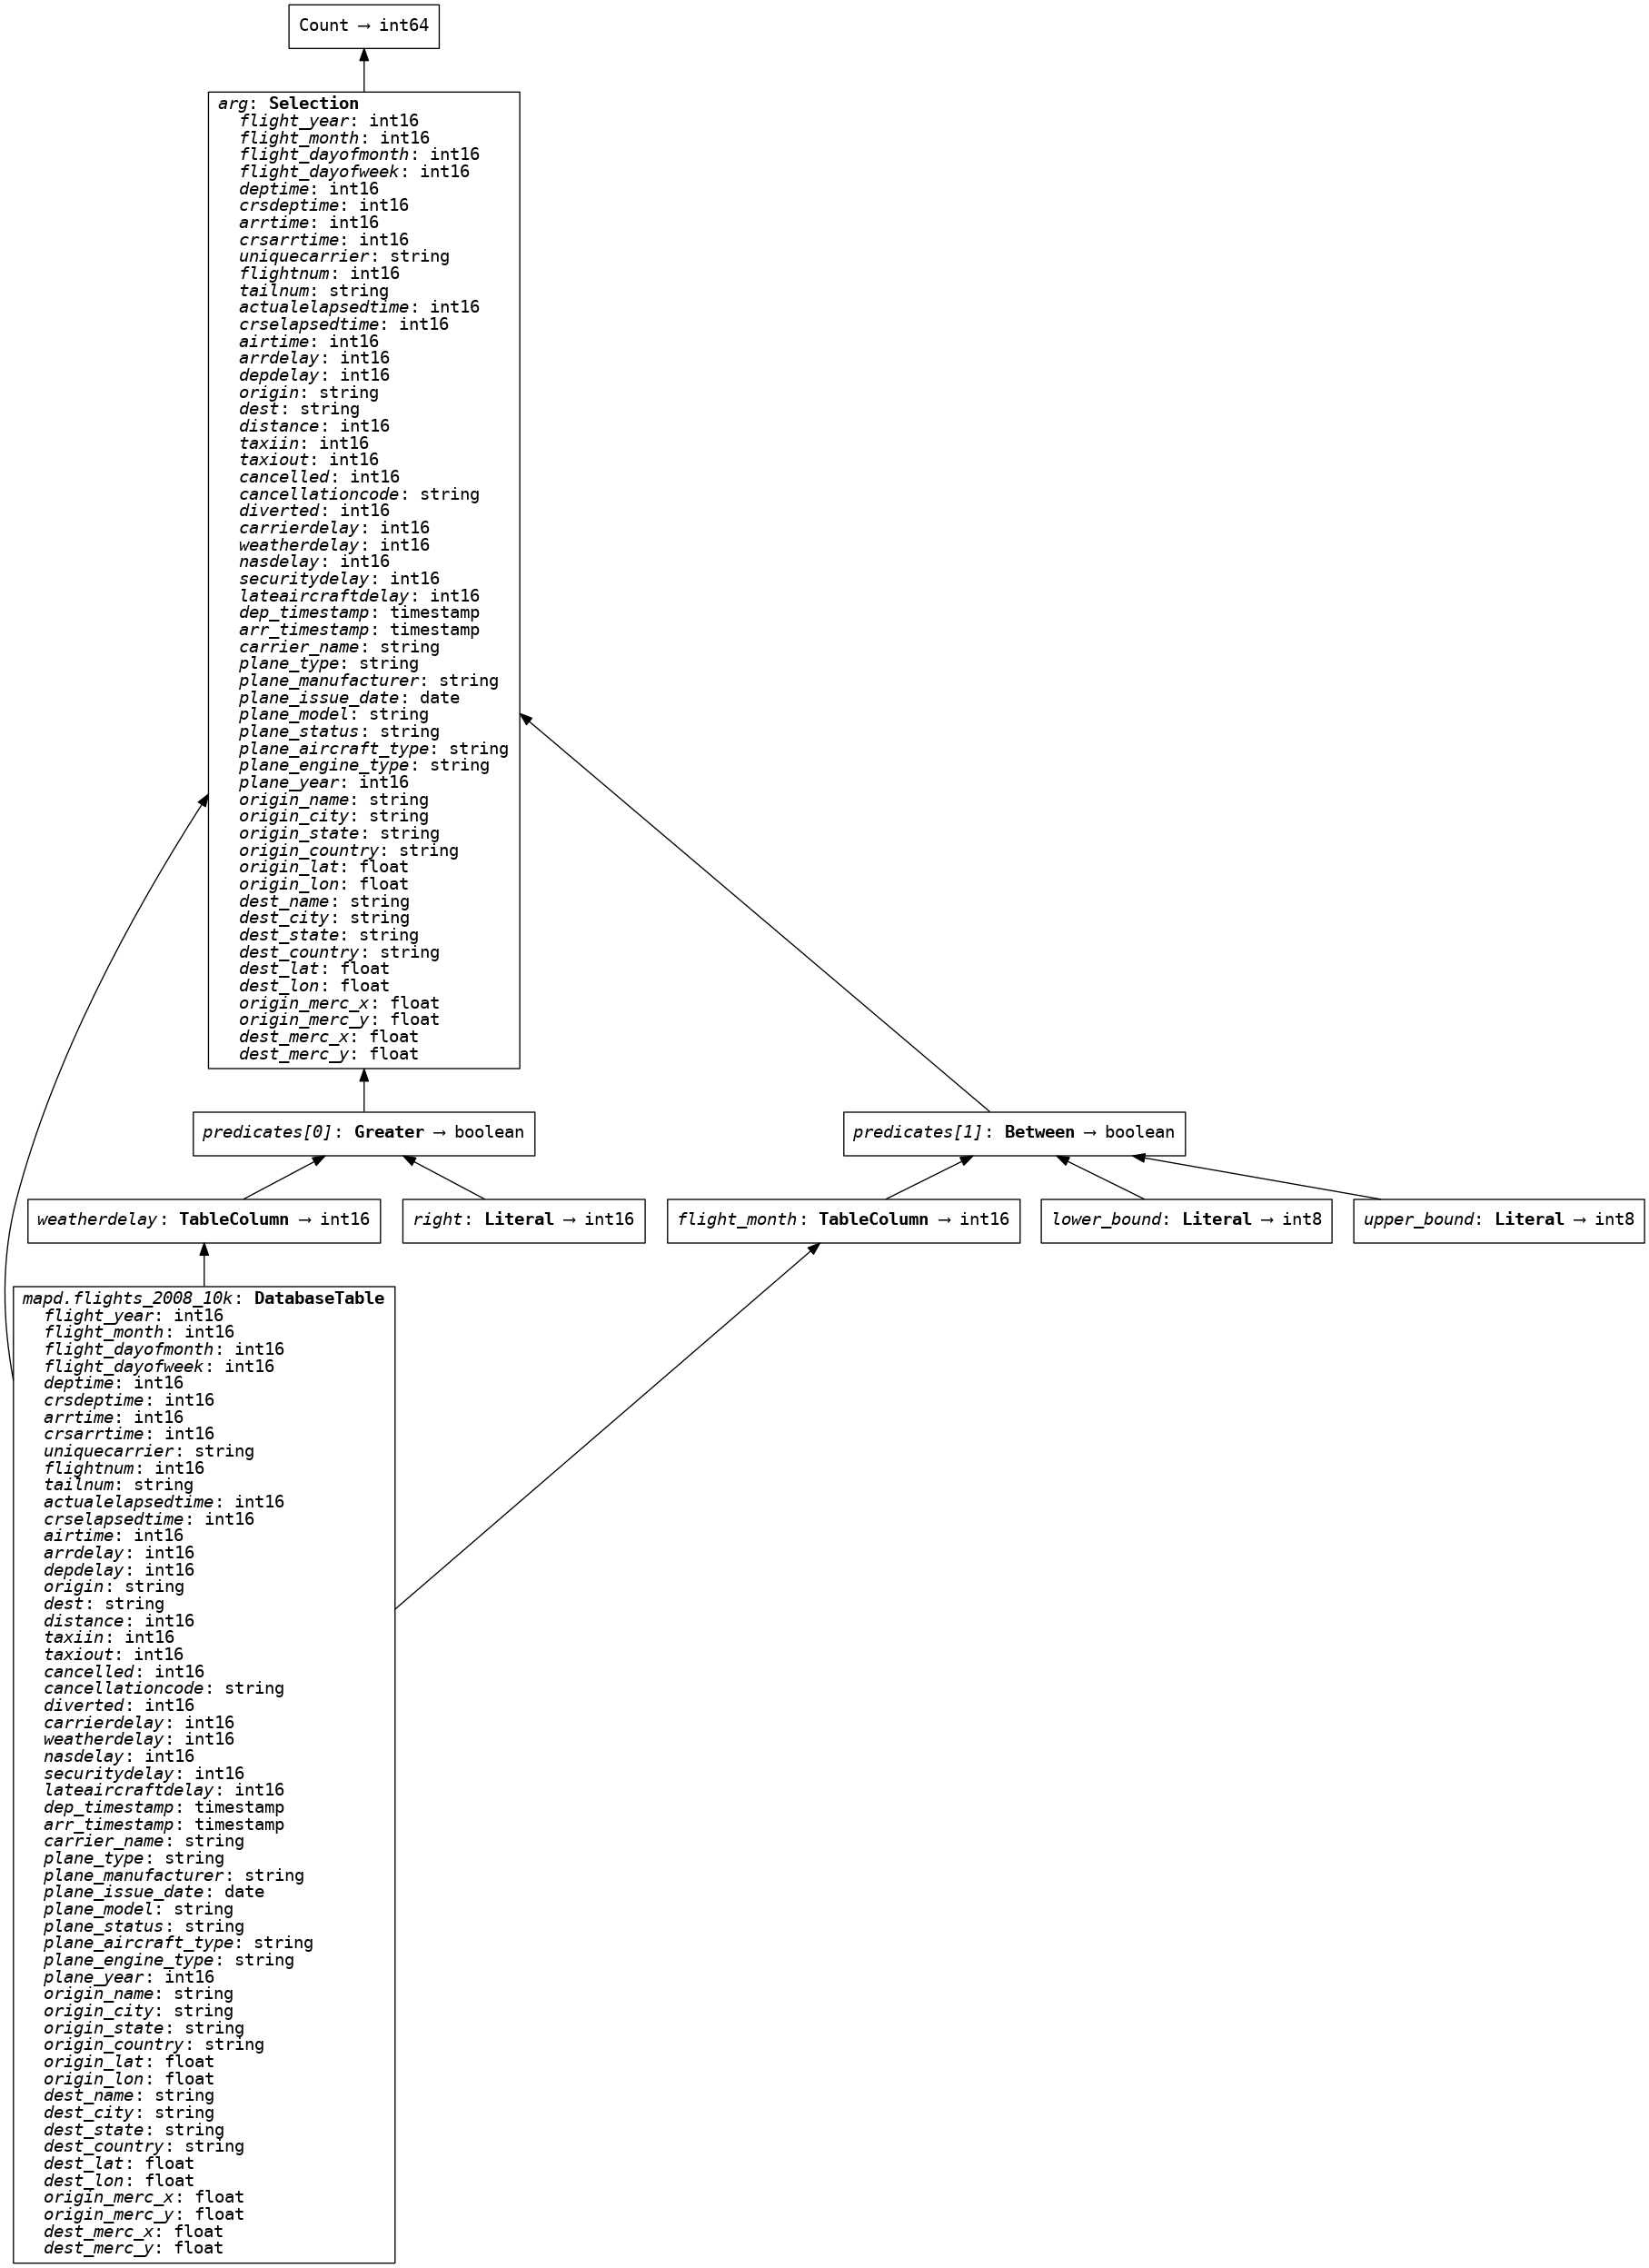

In [32]:
# TODO: resove aggregation name
table[cond1 & cond2].count().name('count1')

## Limits


Like in SQL, the `limit` function selects the indicated numbers of rows from the beginning of a table's result set

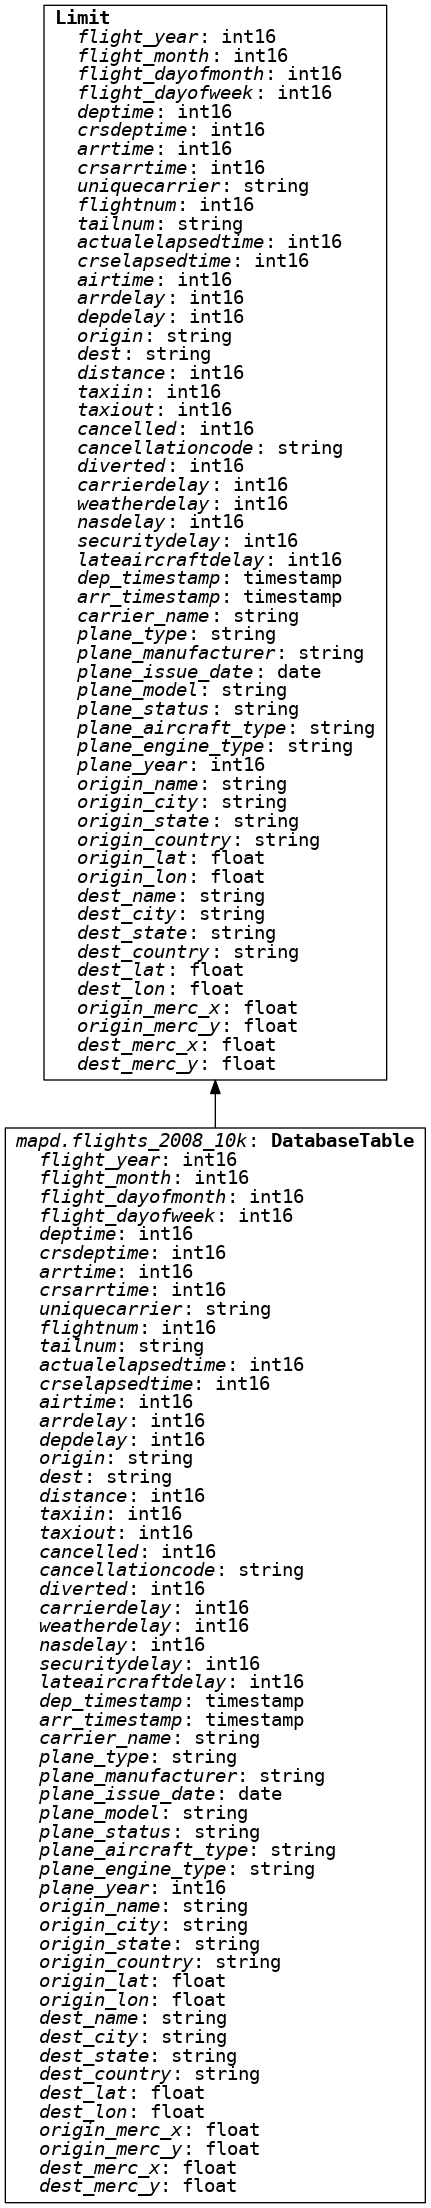

In [33]:
table.limit(2)